# Analyzing demographic variation among US counties using biplots

The data considered here are a single year of population counts for US counties.  The population within each county is partitioned into 2 x 2 x 4 x 19 = 304 demographic cells (sex ⨯ Hispanic ethnicity status ⨯ race ⨯ age).  See the prep.py script for more information.

In [194]:
import numpy as np
import pandas as pd
from prep import demog, births, pop, rucc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Use only the counties for which we have natality data.

In [195]:
fips = np.asarray(births["FIPS"].unique())
demog = demog.loc[demog.index.isin(fips)]

Get the population counts in each race ⨯ ethnicity ⨯ sex cell, aggregating over age groups.

In [196]:
demogy = demog.copy()
demogy.columns = pd.MultiIndex.from_tuples([tuple(x.split("_")) for x in demog.columns])
demogy = demogy.unstack()
demogy = demogy.reset_index()
demogy.columns = ["race", "ethnicity", "sex", "age", "FIPS", "pop"]
demogy.groupby(["race", "ethnicity", "sex"])["pop"].agg(np.sum)

race  ethnicity  sex
A     H          F        476537.0
                 M        476861.0
      N          F       9796219.0
                 M       8999563.0
B     H          F       1513916.0
                 M       1451326.0
      N          F      18800188.0
                 M      16932313.0
N     H          F        814319.0
                 M        863481.0
      N          F        778155.0
                 M        736948.0
W     H          F      22952722.0
                 M      23244882.0
      N          F      74432480.0
                 M      72055692.0
Name: pop, dtype: float64

Restrict the demographics data to the larger counties.

In [197]:
demogx = np.asarray(demog)

Take the fourth root of the data to stabilize variance and symmetrize the data.

In [198]:
demogx = np.power(demogx, 0.25)
demogx[0:4,0:4]

array([[5.50140817, 7.79709796, 8.37852702, 8.53959124],
       [4.62105578, 6.43807142, 6.9521352 , 7.08587051],
       [4.56953094, 6.48990596, 6.93345955, 6.96252817],
       [4.54310108, 6.25523741, 6.70405923, 6.8610793 ]])

Double center the data.

In [199]:
demogx -= demogx.mean()
demogx -= demogx.mean(0)
demogx -= demogx.mean(1)[:, None]

Factor the data matrix

In [200]:
u,s,vt = np.linalg.svd(demogx, 0)
v = vt.T

To understand how many dimensions are contributing variation, we can consider the singular values.  A plot of the raw singular values is not that informative:

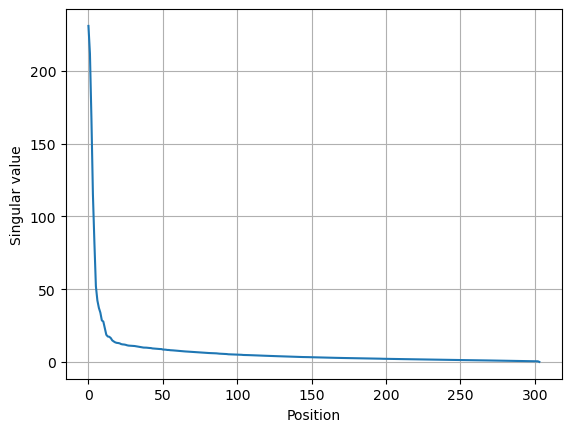

In [201]:
plt.clf()
plt.grid(True)
plt.plot(s)
plt.ylabel("Singular value")
plt.xlabel("Position")
plt.show()

Now we can consider some simple models for the singular values, including an exponential model $\lambda_i = a\exp(-bi)$ or a powerlaw model $\lambda_i = a/i^b$.  These models can be assessed by plotting the singular values in semi-log space or in log space, as shown below.  These plots suggest a "multiphasic" relationship which is not strictly speaking either exponential or powerlaw.  One interpretation is that there are 10-12 large singular values followed by an exponentially decreasing pattern.

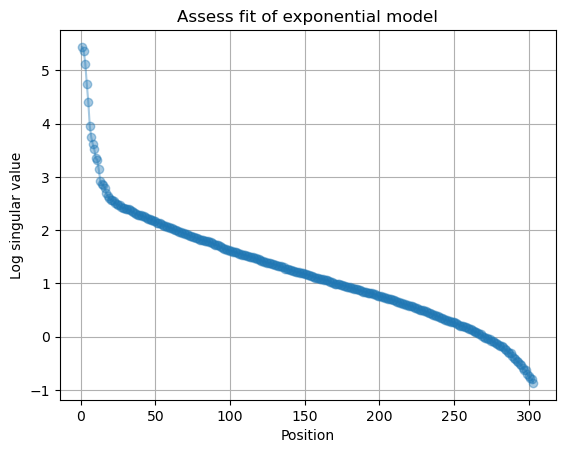

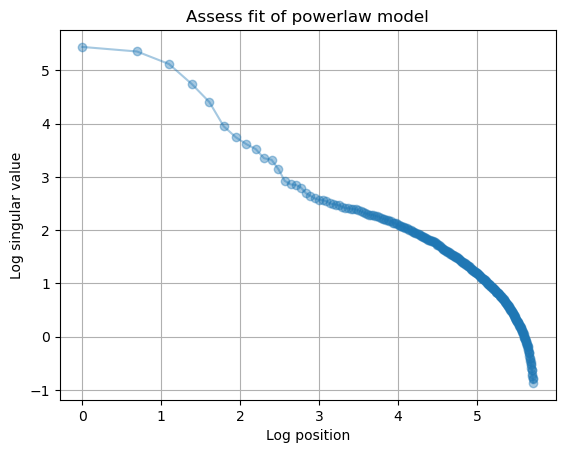

In [202]:
# Semi-log space plot
plt.clf()
plt.grid(True)
ii = np.arange(1, len(s) + 1)
plt.plot(ii[0:-1], np.log(s[0:-1]), "-o", alpha=0.4)
plt.xlabel("Position")
plt.ylabel("Log singular value")
plt.title("Assess fit of exponential model")
plt.show()

# Log space plot
plt.clf()
plt.grid(True)
ii = np.arange(1, len(s) + 1)
plt.plot(np.log(ii[0:-1]), np.log(s[0:-1]), "-o", alpha=0.4)
plt.xlabel("Log position")
plt.ylabel("Log singular value")
plt.title("Assess fit of powerlaw model")
plt.show()

For biplots, the singular values are partitioned between the left
and right singular vectors. alpha = 1 gives a distance
interpretation for rows (counties), alpha = 0 gives a distance
interpretation for columns (demographic categories), alpha = 0.5
does not have a strict distance interpretation.

In [203]:
alpha = 0.5
uu = np.dot(u, np.diag(s**alpha))
vv = np.dot(v, np.diag(s**(1-alpha)))

Specify some parameters for plotting.

In [204]:
colors = {"A": "purple", "B": "orange", "N": "lime", "W": "red"}
lt = {"F": "-", "M": ":"}
sym = {"H": "s", "N": "o"}
ages = range(0, 19)

In [205]:
pdf = PdfPages("biplots_py.pdf")

In [206]:
def generate_biplot(uu, vv, sex, c, j0=0, j1=1):
    """
    Produce a biplot based on the row scores in 'uu' and the column
    scores in vv.  The column labels are in 'c' and the plot is given
    the title 'title'.
    """

    for j in range(2):
        qq = np.quantile(uu[:, j], [0.25, 0.5, 0.75])
        iqr = qq[2] - qq[1]
        ii = np.flatnonzero(np.abs(uu[:, j] - qq[1]) < 5*iqr)
        print("Dropping %d outliers in biplot" % (uu.shape[0] - len(ii)))
        uu = uu[ii, :]
    
    plt.clf()
    plt.figure(figsize=(10, 8))
    ax = plt.axes([0.1, 0.1, 0.76, 0.8])
    ax.grid(True)

    # Plot the counties as grey points
    plt.plot(uu[:, j0], uu[:, j1], 'o', color="grey", alpha=0.3)

    # Plot the demographic categories as colored points, joined
    # by lines connecting the age groups.
    for race in ["A", "B", "N", "W"]:
        for eth in ["H", "N"]:
            la = "%s_%s_%s" % (race, eth, sex)
            ii = [i for (i,x) in enumerate(c) if x.startswith(la)]
            ax.plot(vv[ii, j0], vv[ii, j1], "-o", color=colors[race], label=la, ms=3)
            ax.text(vv[ii[-1], j0], vv[ii[-1], j1], eth, ha="left", va="top", color=colors[race])

    ax.set_xlabel("Component %d" % (j0+1), size=18)
    ax.set_ylabel("Component %d" % (j1+1), size=18)

    ha, lb = ax.get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)
    ax.set_title("Female" if sex == "F" else "Male")

    pdf.savefig()
    plt.show()

To reduce overplotting, produce separate biplots for females and for
males.

In [207]:
def make_biplots(j0, j1):
    for sex in ["F", "M"]:
        c = demog.columns.to_list()
        cx = [x.split("_") for x in c]
        ii = [i for (i,x) in enumerate(cx) if x[2] == sex]
        ii = np.asarray(ii, dtype=int)
        generate_biplot(uu, vv[ii, :], sex, [c[i] for i in ii], j0=j0, j1=j1)

Dropping 2 outliers in biplot
Dropping 11 outliers in biplot


<Figure size 640x480 with 0 Axes>

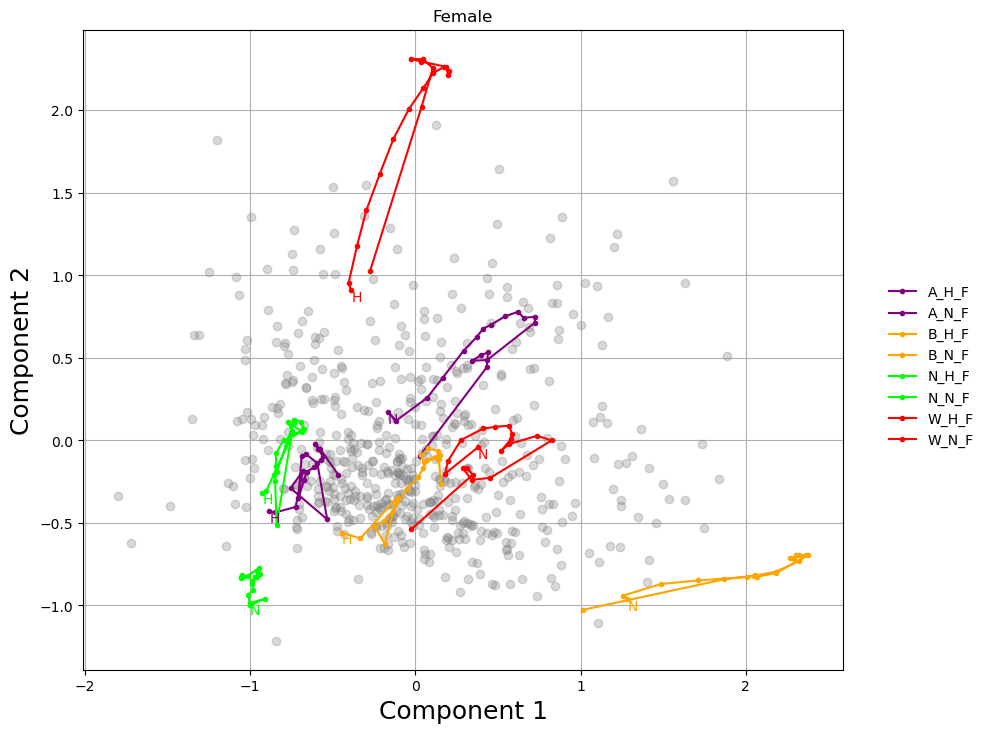

Dropping 2 outliers in biplot
Dropping 11 outliers in biplot


<Figure size 640x480 with 0 Axes>

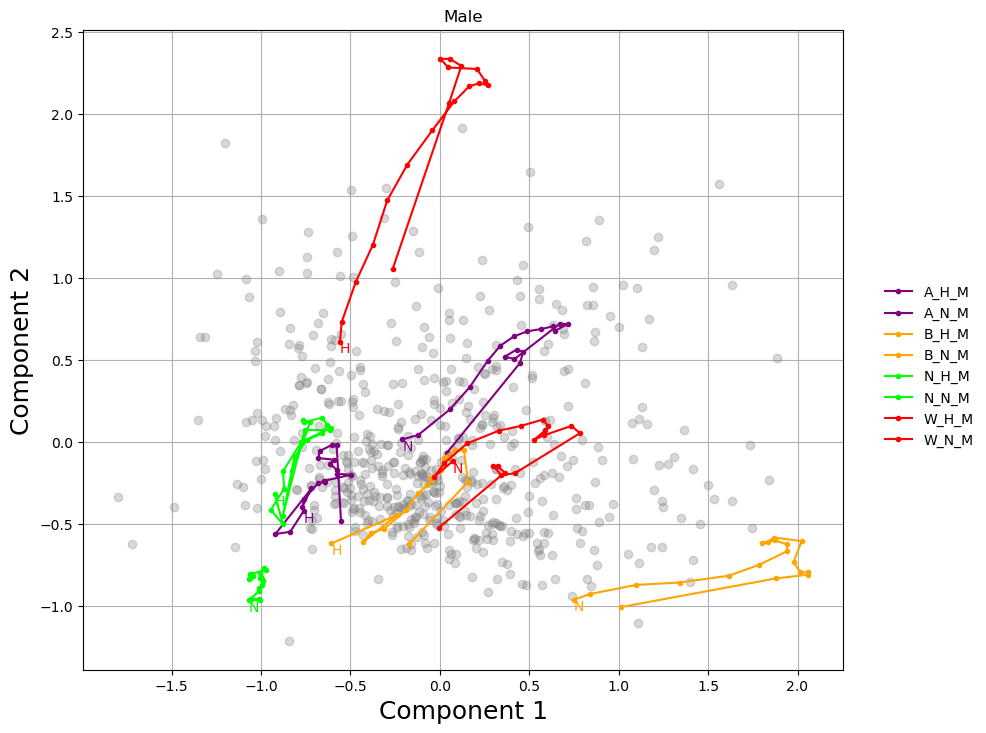

In [208]:
make_biplots(0, 1)

Dropping 2 outliers in biplot
Dropping 11 outliers in biplot


<Figure size 640x480 with 0 Axes>

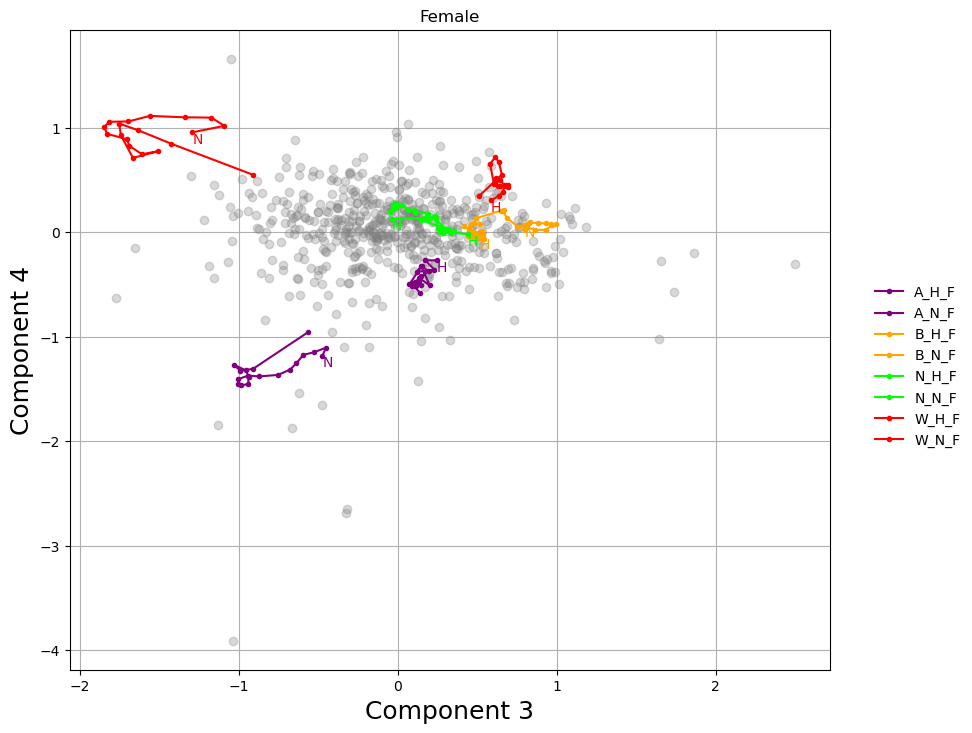

Dropping 2 outliers in biplot
Dropping 11 outliers in biplot


<Figure size 640x480 with 0 Axes>

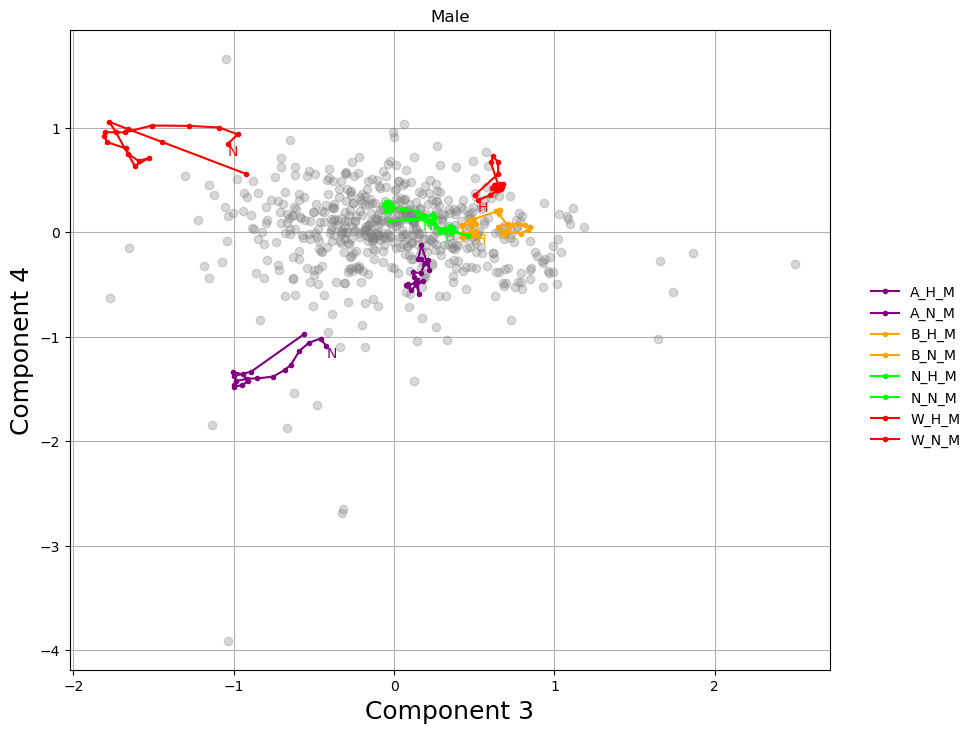

In [209]:
make_biplots(2, 3)

In [210]:
pdf.close()